In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Install Required Libraries
!pip install transformers datasets soundfile speechbrain accelerate -q

In [2]:
import os
import torch
import datasets
from datasets import Audio
from transformers import SpeechT5Processor
from transformers import SpeechT5ForTextToSpeech
from speechbrain.inference import EncoderClassifier
from transformers import Seq2SeqTrainingArguments

In [3]:
# Disable Weights & Biases Logging
import os
os.environ["WANDB_DISABLED"] = "true"

## Step 2: Load and Prepare Dataset

In [4]:
# Load the Dataset: Use the “VoxPopuli” dataset available on Hugging Face, specifically the “it” (Italian) subset, and load only the training split.
ds_path="facebook/voxpopuli"
ds = datasets.load_dataset(ds_path, "it", split="train") # Italian

voxpopuli.py:   0%|          | 0.00/8.84k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

The repository for facebook/voxpopuli contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/voxpopuli.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


data/n_files.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

asr_train.tsv:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

asr_dev.tsv:   0%|          | 0.00/602k [00:00<?, ?B/s]

asr_test.tsv:   0%|          | 0.00/573k [00:00<?, ?B/s]

train_part_0.tar.gz:   0%|          | 0.00/2.14G [00:00<?, ?B/s]

train_part_1.tar.gz:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

train_part_2.tar.gz:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

train_part_3.tar.gz:   0%|          | 0.00/2.18G [00:00<?, ?B/s]

train_part_4.tar.gz:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

dev_part_0.tar.gz:   0%|          | 0.00/565M [00:00<?, ?B/s]

test_part_0.tar.gz:   0%|          | 0.00/547M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [5]:
# Q1
ds

Dataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    num_rows: 22576
})

In [6]:
# Q2
ds[0]["audio"]["sampling_rate"]

16000

In [7]:
# Create a Subset of the Dataset: Shuffle the dataset and take a random quarter (with seed=42) of the entries. This smaller subset will reduce processing time, making it easier to handle on limited resources.

ds_shuff = ds.shuffle(seed=42)

In [8]:
# Convert Audio Sampling Rate: Convert the audio samples in the dataset to a 16 kHz sampling rate, as this is compatible with the model you’ll be using.
ds_frac = ds_shuff.select(range(len(ds_shuff)//4))

In [9]:
ds_frac

Dataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    num_rows: 5644
})

In [10]:
# Convert Audio Sampling Rate: Convert the audio samples in the dataset to a 16 kHz sampling rate, as this is compatible with the model you’ll be using

ds_frac = ds_frac.cast_column("audio", Audio(sampling_rate=16_000))

## Step 3: Load the Model and Tokenizer


In [11]:
# Initialize the TTS Model and Tokenizer: Use the speecht5 model and tokenizer pre-trained on English from the Hugging Face library.

checkpoint="microsoft/speecht5_tts"
model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)
processor = SpeechT5Processor.from_pretrained(checkpoint)
tokenizer = processor.tokenizer


config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [30]:
# Q5

tokenizer.total_vocab_size

81

In [13]:
# Tokenize and Generate Audio Output: Create a test sentence and tokenize it. Use the model to generate an audio waveform from this text to confirm the setup is working.

# at the end of step 6

# Step 4: Preprocess the Dataset Text

In [14]:
# Extract Vocabulary from Dataset: Extract unique characters from the “normalized text” column in the dataset to build a vocabulary of characters used in the data.

def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

In [19]:
vocabs = ds_frac.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=ds_frac.column_names,
)

Map:   0%|          | 0/5644 [00:00<?, ? examples/s]

In [20]:
# Q3
len(vocabs["vocab"][0])

40

In [31]:
# Identify Unsupported Characters: Compare the characters in the dataset vocabulary with the tokenizer’s vocabulary. Determine if there are any characters in the dataset that are not supported by the tokenizer.

dataset_vocab = set(vocabs["vocab"][0])

# get all individual tokens from the model
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

In [32]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'è', 'ì', 'ï', 'ò', 'ó', 'ù'}

In [23]:
replacements = [
    ("à", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ü", "u"),
]

In [40]:
def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs

# Replace Unsupported Characters: Define replacements for unsupported characters (such as accented letters) with simpler versions. Apply these replacements to clean up the text data.
dataset = ds_frac.map(cleanup_text)

In [41]:
# Q4
# tokenizer_vocab

# Step 5: Speaker Analysis

In [42]:
# Analyze Speaker Distribution: Count the number of examples per speaker in the dataset to understand the distribution of samples across speakers.

from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id]+=1

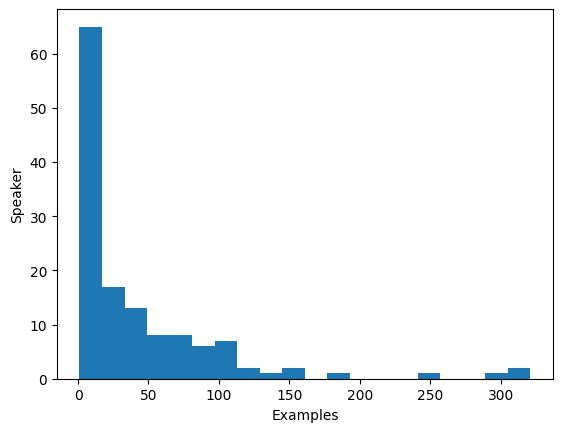

In [43]:
# Visualize Speaker Data: Plot a histogram of the number of examples per speaker. This will help you understand which speakers are well-represented and which have fewer examples.

import matplotlib.pyplot as plt

plt.figure()

plt.hist(speaker_counts.values(), bins=20)

plt.ylabel("Speaker")
plt.xlabel("Examples")
plt.show()

In [44]:
# Q7
sc = 0

for spk_id, c in speaker_counts.items():
    if c <= 100:
        sc+=1
sc

119

In [46]:
# Filter Speaker Data: Filter the dataset to include only those speakers who have between 100 and 400 examples to ensure a balanced distribution.

def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/2570 [00:00<?, ? examples/s]

In [50]:
# Q8
dataset

Dataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    num_rows: 2570
})

# Step 6: Load Speaker Embeddings



In [54]:
spk_model_name="speechbrain/spkrec-xvect-voxceleb"

In [55]:
torch.cuda.is_available()

True

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the Speaker Model: Use a pre-trained x-vector EncoderClassifier model from SpeechBrain to generate speaker embeddings. Ensure that the model is compatible with your system (CUDA if available).

speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

# Generate Speaker Embeddings: Define a function that generates and normalizes speaker embeddings for each audio sample in the dataset. These embeddings capture the unique characteristics of each speaker’s voice

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embedding = speaker_model.encode_batch(torch.tensor(waveform).to(device))
        speaker_embedding = torch.nn.functional.normalize(speaker_embedding, dim=-2)
        speaker_embedding = speaker_embedding.squeeze().cpu().numpy()
    return speaker_embedding

hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

In [57]:
# Define a Preprocessing Function: Create a function that prepares each dataset example. The function should:
# Tokenize the text.
# Convert audio to log-mel spectrograms.
# Add the speaker embeddings. (step 7)

def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False
    )

    # strip off the batch dimensions
    example["labels"] = example["labels"][0]
    #  use speechbrain to obtain x-vector

    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])
    return example

In [58]:
dataset

Dataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    num_rows: 2570
})

In [59]:


processed_example = prepare_dataset(dataset[0])
# processed_example
processed_example["speaker_embeddings"].shape

(512,)

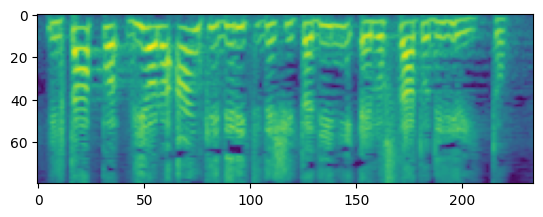

In [60]:
plt.imshow(processed_example["labels"].T)
plt.show()

In [61]:
# sent = "How are you?"
# input_ids = tokenizer(sent, return_tensors="pt").input_ids[0]
# input_ids
# model.generate(input_ids, speaker_embeddings=processed_example["speaker_embeddings"])

# Step 7: Process the Dataset for Model Input

In [63]:
# Apply the Preprocessing Function: Apply the preprocessing function to each example in the dataset. This may take some time, depending on the dataset size.

dss = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/2570 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (848 > 600). Running this sequence through the model will result in indexing errors


In [65]:
# Filter Out Long Texts: To ensure efficient training, filter out examples where the tokenized text length exceeds 200 tokens.

def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length <= 200

dataset = dss.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

1418

In [66]:
# Split the Dataset: Split the dataset into training and test sets with a 90:10 ratio.

dataset = dataset.train_test_split(test_size=0.1, seed=42)

In [67]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 1276
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 142
    })
})

# Step 8: Define a Custom Data Collator

Define the Data Collator Class: Create a custom data collator that:

Pads input sequences to the same length.

Pads spectrogram labels with a special value to ignore during loss computation.

Adjusts labels to fit the model’s reduction factor.

Adds speaker embeddings to each batch.

In [68]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:

    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # input
        batch = self.processor.pad(
            input_ids=input_ids,
            labels=label_features,
            # padding=self.padding,
            # max_length=self.max_length,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly

        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        del batch["decoder_attention_mask"]

        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )

            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in speaker embeddings

        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [69]:
# Instantiate the Data Collator: Initialize the data collator with the processor object used for padding inputs and labels.

data_collator=TTSDataCollatorWithPadding(processor=processor)

# Step 9: Configure Training Parameters

Set Training Arguments: Define training arguments for Seq2SeqTrainingArguments, including:

Batch size, learning rate, and warmup steps.

Enable gradient checkpointing to save memory.

Configure mixed precision and evaluation steps.

Enable load_best_model_at_end for best model tracking.

In [70]:
training_args = Seq2SeqTrainingArguments(
    output_dir = "speecht5_finetuned_voxpopuli_it",  
    per_device_train_batch_size = 8,  
    gradient_accumulation_steps = 4,  
    learning_rate = 1e-4,  
    warmup_steps = 200,  
    max_steps = 1000,
    gradient_checkpointing = True,
    fp16 = True,  
    evaluation_strategy = "steps",
    per_device_eval_batch_size = 4,
    save_steps = 500,  
    eval_steps = 500,  
    logging_steps = 50,  
    load_best_model_at_end = True,
    greater_is_better = False,
    label_names = ["labels"],
    push_to_hub = False,  
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


The use_cache=True option is incompatible with gradient checkpointing. Disable it for training, and re-enable cache for generation to speed-up inference time:

In [71]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

# Step 10: Train the Model

In [72]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
500,0.500100,0.502330


/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


And with that, we’re ready to start training! Training will take several hours. Depending on your GPU, it is possible that you will encounter a CUDA “out-of-memory” error when you start training. In this case, you can reduce the per_device_train_batch_size incrementally by factors of 2 and increase gradient_accumulation_steps by 2x to compensate.

Start Training: Train the model. If encountering a CUDA “out-of-memory” error, gradually reduce the batch size and adjust gradient accumulation steps to compensate.

# Step 11: Perform Inference

Load the Fine-tuned Model: After training, load the fine-tuned model.

Prepare Inference Input: Select a speaker embedding and create a test sentence in Italian.

Generate Speech Output: Use a vocoder model (such as SpeechT5HifiGan) to convert the model’s output to audio. 

Listen to the generated audio to evaluate the results.

In [ ]:
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)


In [ ]:
text = "Ciao a tutti, parlo italiano. Un saluto a tutti!"

In [ ]:
# preprocess the input
inputs = processor(text=text, return_tensors="pt")

In [ ]:
# Instantiate a vocoder and generate speech

from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [ ]:
from IPython.display import Audio

Audio(speech.numpy(), rate=16000)